In [1]:
!conda activate cloudspace
import torch
print(torch.cuda.is_available())

True


In [2]:
import json
import cv2
import numpy as np
import h5py

from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self):
        self.data = []
        with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
            images = f['images'][:]
            labels = f['labels'][:]
            for i in range(len(images)):
                newimg=np.transpose(images[i], (2, 1, 0))
                newlabel=np.transpose(labels[i], (1, 0))
                new_width = newimg.shape[1] // 2
                new_height = newimg.shape[0] // 2  
                self.data.append({
                    'image': cv2.resize(newimg, (256,256)),
                    'label': cv2.resize(newlabel, (256, 256)) ,
                    'prompt': 'An indoors design'
                })
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        source = item['label']
        target = item['image']
        prompt = item['prompt']

        # source = cv2.imread('./training/fill50k/' + source_filename)
        # target = cv2.imread('./training/fill50k/' + target_filename)

        # Do not forget that OpenCV read images in BGR order.
        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        # Normalize source images to [0, 1].
        source = source.astype(np.float32) / 255.0

        # Normalize target images to [-1, 1].
        target = (target.astype(np.float32) / 127.5) - 1.0

        return {'jpg': target, 'txt': prompt, 'hint': source}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1449
An indoors design
(256, 256, 3)
(256, 256, 3)


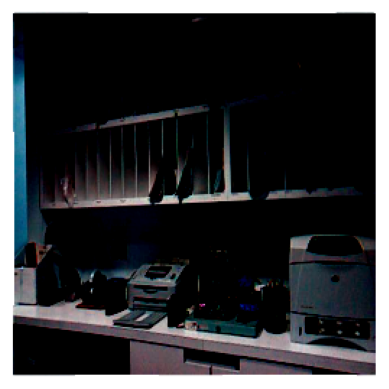

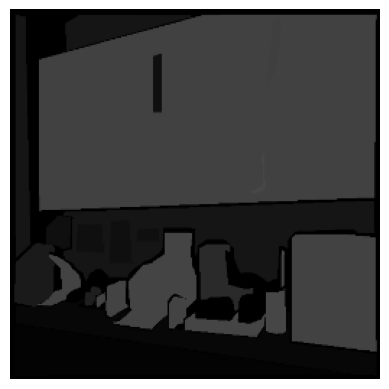

In [3]:
import matplotlib.pyplot as plt
dataset = MyDataset()
print(len(dataset))

item = dataset[10]
jpg = item['jpg']
txt = item['txt']
hint = item['hint']
print(txt)
print(jpg.shape)
print(hint.shape)

plt.imshow(jpg, cmap='gray' if jpg.ndim == 2 else None)
plt.axis('off')  # Turn off axis labels for a cleaner display
plt.show()

plt.imshow(hint, cmap='gray' if hint.ndim == 2 else None)
plt.axis('off')  # Turn off axis labels for a cleaner display
plt.show()

In [9]:
import pytorch_lightning as pl
import csv
from pytorch_lightning.callbacks import Callback

class LossLoggerCallback(Callback):
    def __init__(self):
        super().__init__()
        self.losses = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Log the loss at each training batch end
        loss = outputs['loss'].detach().cpu().item()  # Make sure to detach from the graph
        self.losses.append(loss)

    def on_train_end(self, trainer, pl_module):
        # Save the loss history to a CSV file at the end of training
        with open('./training_losses.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['Step', 'Loss'])
            for i, loss in enumerate(self.losses):
                writer.writerow([i, loss])
        print("Training losses saved to './training_losses.csv'")


In [10]:
from share import *

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from cldm.logger import ImageLogger
from cldm.model import create_model, load_state_dict
from pytorch_lightning.callbacks import ModelCheckpoint


# Configs
resume_path = './models/control_sd15_seg.pth'
save_path = './models/updated_control_sd15_seg.pth'
batch_size = 4
logger_freq = 300
learning_rate = 1e-5
sd_locked = True
only_mid_control = False


# First use cpu to load models. Pytorch Lightning will automatically move it to GPUs.
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(resume_path, location='cpu'))
model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control
loss_logger_callback = LossLoggerCallback()

checkpoint_callback = ModelCheckpoint(
    dirpath='./models',            
    filename='updated_control_sd15_seg-{epoch:02d}-{step}',
    save_top_k=1                               
)


# Misc
dataset = MyDataset()
dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = ImageLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(gpus=1, precision=16, callbacks=[logger,checkpoint_callback,loss_logger_callback],max_epochs=30)


# Train!
trainer.fit(model, dataloader)

logging improved.
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_seg.pth]


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:280: LightningDeprecationWarning: Base `LightningModule.on_train_batch_start` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  rank_zero_deprecation(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:287: LightningDeprecationWarning: Base `Callback.on_train_batch_end` hook signature has c

Training: 0it [00:00, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.97it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.97it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.93it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.95it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.89it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.89it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.93it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.99it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.95it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.99it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.97it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.97it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.89it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.95it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.88it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.01it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.96it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


Training losses saved to './training_losses.csv'


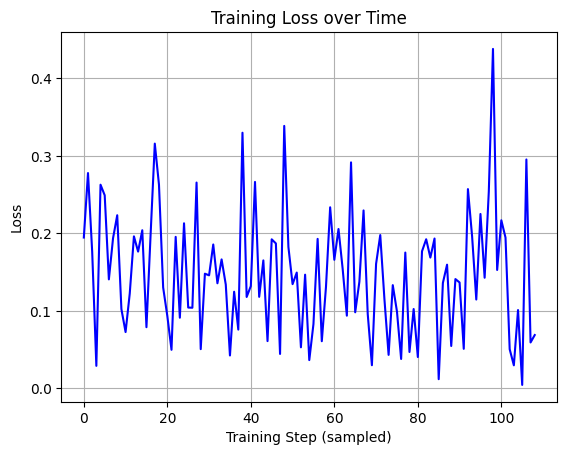

In [4]:
# Sample every 100th point for a cleaner plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the loss data
loss_data = pd.read_csv('./training_losses.csv')

# Extract only the loss values as an array
ypoints = np.array(loss_data['Loss'])

sampled_ypoints = ypoints[::100]  # Adjust the number to control how many points to skip

plt.plot(sampled_ypoints, linestyle='-', marker='', color='b')  # No marker, just a line
plt.xlabel('Training Step (sampled)')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.show()


In [13]:
from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.uniformer import UniformerDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

save_path = './models/saved_model.pth'
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(save_path, location='cuda'))
model=model.cuda()
ddim_sampler = DDIMSampler(model)
apply_uniformer = UniformerDetector()

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/saved_model.pth]
Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /teamspace/studios/this_studio/ControlNet/annotator/ckpts/upernet_global_small.pth


In [17]:
from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.uniformer import UniformerDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

save_path = './models/control_sd15_seg.pth'
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(save_path, location='cuda'))
model=model.cuda()
ddim_sampler = DDIMSampler(model)
apply_uniformer = UniformerDetector()

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_seg.pth]
Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /teamspace/studios/this_studio/ControlNet/annotator/ckpts/upernet_global_small.pth


In [18]:
import torch
import random
import einops
import numpy as np
import cv2
import config

def process(input_images, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta):
    results = []
    with torch.no_grad():
        for input_image in input_images:
            # Preprocess the input image
            input_image = HWC3(input_image)
            detected_map = apply_uniformer(resize_image(input_image, detect_resolution))
            img = resize_image(input_image, image_resolution)
            H, W, C = img.shape

            detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_NEAREST)

            # Prepare control tensor
            control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
            control = torch.stack([control for _ in range(num_samples)], dim=0)
            control = einops.rearrange(control, 'b h w c -> b c h w').clone()

            # Set the random seed if needed
            if seed == -1:
                seed = random.randint(0, 65535)
            seed_everything(seed)

            # Adjust memory settings if configured
            if config.save_memory:
                model.low_vram_shift(is_diffusing=False)

            # Prepare conditioning and unconditioning
            cond = {
                "c_concat": [control], 
                "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]
            }
            un_cond = {
                "c_concat": None if guess_mode else [control], 
                "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]
            }
            shape = (4, H // 8, W // 8)

            if config.save_memory:
                model.low_vram_shift(is_diffusing=True)

            # Apply control scales
            model.control_scales = ([strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else [strength] * 13)

            # Run sampling
            samples, intermediates = ddim_sampler.sample(
                ddim_steps, num_samples, shape, cond, verbose=False, eta=eta,
                unconditional_guidance_scale=scale,
                unconditional_conditioning=un_cond
            )

            if config.save_memory:
                model.low_vram_shift(is_diffusing=False)

            # Decode the generated samples
            x_samples = model.decode_first_stage(samples)
            x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

            # Take the first generated result from the batch as the single output image
            results.append(x_samples[0])  # Only taking the first image in each batch

    # Return the processed results for each input image
    return results

In [19]:
import h5py
# Example usage:
input_images=[]
with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
    images = f['labels'][:]             
    for i in range(len(images)):
        newimg=np.transpose(images[i], (1, 0))
        new_width = newimg.shape[1] // 2
        new_height = newimg.shape[0] // 2  
        resized_img=cv2.resize(newimg, (256,256))
        if resized_img.dtype != np.uint8:
            resized_img = (resized_img * 255).astype(np.uint8) if resized_img.max() <= 1 else resized_img.astype(np.uint8)
        input_images.append(resized_img)
  
output_images = process(
    input_images[:100], 
    prompt="An indoors design", 
    a_prompt="additional prompt", 
    n_prompt="negative prompt",
    num_samples=1, 
    image_resolution=256, 
    detect_resolution=256, 
    ddim_steps=50, 
    guess_mode=False, 
    strength=1.0, 
    scale=7.5, 
    seed=42, 
    eta=0.0
)

import os
output_folder = 'output_images1'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through the output images and save them
for idx, image in enumerate(output_images):
    # Define the file path to save the image
    image_path = os.path.join(output_folder, f"output_image_{idx + 1}.png")
    
    # Save the image using OpenCV (assuming the image is in uint8 format)
    cv2.imwrite(image_path, image)
    print(f"Image saved at: {image_path}")

# output_images will contain one processed image for each input image

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.12it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.08it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.06it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.05it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.04it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.00it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.00it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.00it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.99it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.99it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.99it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.99it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Image saved at: output_images1/output_image_1.png
Image saved at: output_images1/output_image_2.png
Image saved at: output_images1/output_image_3.png
Image saved at: output_images1/output_image_4.png
Image saved at: output_images1/output_image_5.png
Image saved at: output_images1/output_image_6.png
Image saved at: output_images1/output_image_7.png
Image saved at: output_images1/output_image_8.png
Image saved at: output_images1/output_image_9.png
Image saved at: output_images1/output_image_10.png
Image saved at: output_images1/output_image_11.png
Image saved at: output_images1/output_image_12.png
Image saved at: output_images1/output_image_13.png
Image saved at: output_images1/output_image_14.png
Image saved at: output_images1/output_image_15.png
Image saved at: output_images1/output_image_16.png
Image saved at: output_images1/output_image_17.png
Image saved at: output_images1/output_image_18.png
Image saved at: output_images1/output_image_19.png
Image saved at: output_images1/output_im

In [15]:
import os
output_folder = 'real_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
    images = f['images'][:] 
    images=images[:100]
    for i in range(len(images)):
        newimg=np.transpose(images[i], (2, 1, 0))
        new_width = newimg.shape[1] // 2
        new_height = newimg.shape[0] // 2  
        resized_img=cv2.resize(newimg, (256,256))
        if resized_img.dtype != np.uint8:
            resized_img = (resized_img * 255).astype(np.uint8) if resized_img.max() <= 1 else resized_img.astype(np.uint8)
        image_path = os.path.join(output_folder, f"real_image_{i+ 1}.png")
        cv2.imwrite(image_path, resized_img)

In [3]:
import torch

# Load the checkpoint
checkpoint = torch.load("./models/updated_control_sd15_seg-epoch=29-step=10889.ckpt")

# Extract the state_dict
# Sometimes the checkpoint may include extra metadata, so you may need to adjust this depending on the structure.
# Common structures:
# 1. checkpoint['state_dict'] - if 'state_dict' is stored as a separate key.
# 2. checkpoint - if the checkpoint itself is the state_dict.

# Check for structure and assign accordingly
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Save the model's state_dict as a .pth file
torch.save(state_dict, "./models/saved_model.pth")
